In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import tensorflow as tf
import pyupbit
import pybithumb
import ccxt
import datetime
%matplotlib inline
import ccxt

binance = ccxt.binance()
markets = binance.fetch_tickers()

<ipython-input-8-83474f381318>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft['Date'][i] = datetime.datetime.fromtimestamp(dft['Date'][i]/1000).strftime('%Y-%m-%d %H:%M:%S')
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasona

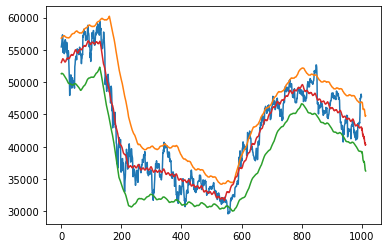

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


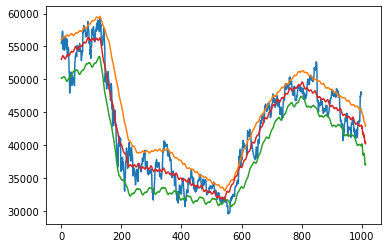

In [8]:
ohlcv = binance.fetch_ohlcv('BTC/USDT', timeframe='4h', limit=14000)
dft = pd.DataFrame(ohlcv, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
for i in dft.index:
    dft['Date'][i] = datetime.datetime.fromtimestamp(dft['Date'][i]/1000).strftime('%Y-%m-%d %H:%M:%S')
dft.set_index('Date', inplace=True)
n = 42
dft['ndays_high'] = dft['High'].rolling(window=n, min_periods=1).max()
dft['ndays_low'] = dft['Low'].rolling(window=n, min_periods=1).min()
dfh = pd.DataFrame(dft.sort_index().reset_index(), columns=['Date', 'Close', 'ndays_high', 'ndays_low'])
dfhh = dfh.rename(columns = {'Date':'ds', 'ndays_high':'y'})
dfhl = dfh.rename(columns = {'Date':'ds', 'ndays_low':'y'})
dfhc = dfh.rename(columns = {'Date':'ds', 'Close':'y'})
from prophet import Prophet
mh = Prophet()
ml = Prophet()
mc = Prophet()
mh.fit(dfhh)
ml.fit(dfhl)
mc.fit(dfhc)
futurel = ml.make_future_dataframe(periods=14)
futureh = mh.make_future_dataframe(periods=14)
futurec = mc.make_future_dataframe(periods=14)
forecasth = mh.predict(futureh)
forecastl = ml.predict(futurel)
forecastc = mc.predict(futurel)
plt.plot(dfh['Close'], label='Close')
plt.plot(forecasth['yhat'], label='ndays_high')
plt.plot(forecastl['yhat'], label='ndays_low')
plt.plot(forecastc['yhat'], label='Close')
plt.show()
n = 21
dft['ndays_high'] = dft['High'].rolling(window=n, min_periods=1).max()
dft['ndays_low'] = dft['Low'].rolling(window=n, min_periods=1).min()
dfh = pd.DataFrame(dft.sort_index().reset_index(), columns=['Date', 'Close', 'ndays_high', 'ndays_low'])
dfhh = dfh.rename(columns = {'Date':'ds', 'ndays_high':'y'})
dfhl = dfh.rename(columns = {'Date':'ds', 'ndays_low':'y'})
dfhc = dfh.rename(columns = {'Date':'ds', 'Close':'y'})
from prophet import Prophet
mh = Prophet()
ml = Prophet()
mc = Prophet()
mh.fit(dfhh)
ml.fit(dfhl)
mc.fit(dfhc)
futurel = ml.make_future_dataframe(periods=14)
futureh = mh.make_future_dataframe(periods=14)
futurec = mc.make_future_dataframe(periods=14)
forecasth = mh.predict(futureh)
forecastl = ml.predict(futurel)
forecastc = mc.predict(futurel)
plt.plot(dfh['Close'], label='Close')
plt.plot(forecasth['yhat'], label='ndays_high')
plt.plot(forecastl['yhat'], label='ndays_low')
plt.plot(forecastc['yhat'], label='Close')
plt.show()